In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#### First sight into data

In [2]:
def get_titanic_data():
    train_data = pd.read_csv("../data/titanic/train.csv")
    test_data = pd.read_csv("../data/titanic/test.csv")
    return train_data, test_data

train_data, test_data = get_titanic_data()

In [3]:
print train_data.shape
print test_data.shape

(891, 12)
(418, 11)


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [8]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [65]:
target_column = 'Survived'
continuous_column_list = ['Age', 'SibSp', 'Fare',
                      'Parch']
discrete_column_list = ['Sex', 'Pclass', 'Embarked']
text_column_list = ['Name', 'Ticket', 'Cabin']

continuous_train_data = train_data.filter(continuous_column_list)
discrete_train_data = train_data.filter(discrete_column_list)

# y_train = train_data['Survived']
# X_train = train_data.drop(useless_column_list, axis=1)
# X_test = test_data.drop(useless_column_test_list, axis=1)

In [9]:
continuous_train_data.describe()

,Age,SibSp,Fare,Parch
count,714.000000,891.000000,891.000000,891.000000
mean,29.699118,0.523008,32.204208,0.381594
std,14.526497,1.102743,49.693429,0.806057
min,0.420000,0.000000,0.000000,0.000000
25%,20.125000,0.000000,7.910400,0.000000
50%,28.000000,0.000000,14.454200,0.000000
75%,38.000000,1.000000,31.000000,0.000000
max,80.000000,8.000000,512.329200,6.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10a9b6c90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10af51f90>]], dtype=object)

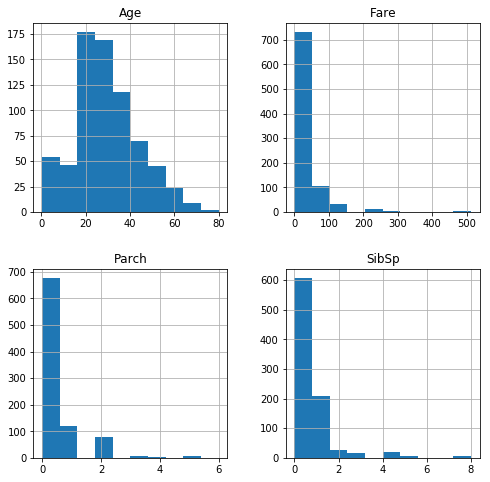

In [16]:
continuous_train_data.hist(figsize=(8, 8))

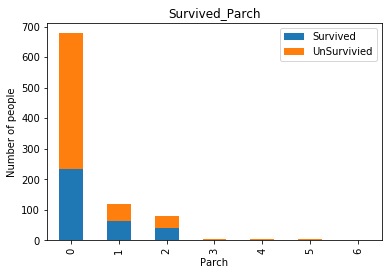

Parch
0    [[Axes(0.125,0.125;0.775x0.755)]]
1    [[Axes(0.125,0.125;0.775x0.755)]]
2    [[Axes(0.125,0.125;0.775x0.755)]]
3    [[Axes(0.125,0.125;0.775x0.755)]]
4    [[Axes(0.125,0.125;0.775x0.755)]]
5    [[Axes(0.125,0.125;0.775x0.755)]]
6    [[Axes(0.125,0.125;0.775x0.755)]]
dtype: object

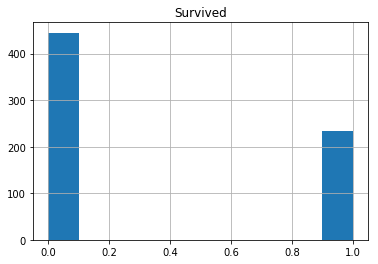

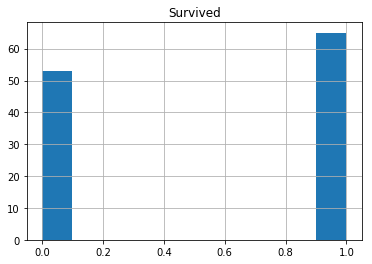

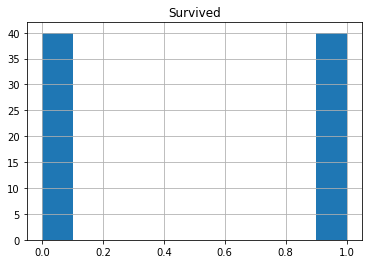

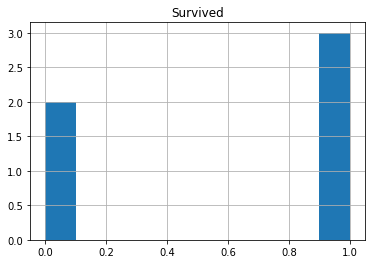

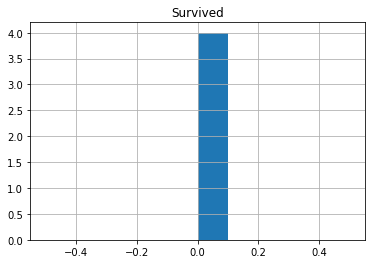

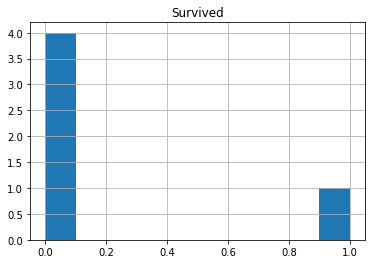

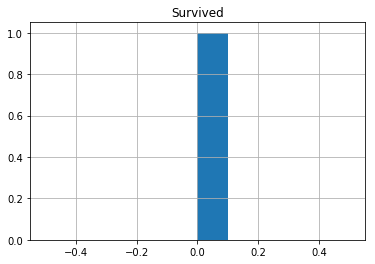

In [45]:
feature = 'Parch'
feature_data = train_data.filter([feature, 'Survived'])
survived_data = feature_data[feature][feature_data.Survived == 1].value_counts()
unsurvived_data = feature_data[feature][feature_data.Survived == 0].value_counts()
df = pd.DataFrame({'Survived': survived_data, 'UnSurvivied': unsurvived_data})
df.plot(kind='bar', stacked=True)
plt.title('Survived_' + feature)
plt.xlabel(feature)
plt.ylabel(u'Number of people')
plt.show()

feature_data.groupby(feature).hist()

In [56]:
from scipy.stats import pearsonr
print "Parch:", pearsonr(train_data["Parch"], train_data['Survived'])
print "SibSp:", pearsonr(train_data["SibSp"], train_data['Survived'])
print "PassengerId:", pearsonr(train_data["PassengerId"], train_data['Survived'])

Parch: (0.081629407083483485, 0.0147992453747224)
SibSp: (-0.035322498885735583, 0.29224392869817906)
PassengerId: (-0.0050066607670664854, 0.88136577687981443)


In [55]:
from minepy import MINE
def mic(x, y):
    m = MINE()
    m.compute_score(x, y)
    return (m.mic(), 0.5)

print "Parch:", mic(train_data["Parch"], train_data['Survived'])
print "SibSp:", mic(train_data["SibSp"], train_data['Survived'])
print "PassengerId:", mic(train_data["PassengerId"], train_data['Survived'])

Parch: (0.023610547633470973, 0.5)
SibSp: (0.03346632133871006, 0.5)
PassengerId: (0.13425000935219458, 0.5)


In [63]:
from sklearn.feature_selection import chi2
print "Parch:", chi2(train_data.filter(["Parch"]), train_data['Survived'])
print "SibSp:", chi2(train_data.filter(["SibSp"]), train_data['Survived'])

 Parch: (array([ 10.09749911]), array([ 0.00148471]))
SibSp: (array([ 2.58186538]), array([ 0.10809421]))


##### 离散值分析

In [69]:
for column in discrete_train_data.columns:
    print discrete_train_data[column].value_counts()

male      577
female    314
Name: Sex, dtype: int64
3    491
1    216
2    184
Name: Pclass, dtype: int64
S    644
C    168
Q     77
Name: Embarked, dtype: int64


In [83]:
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
sex_label_data = LabelBinarizer().fit_transform(train_data['Sex'])
embarked_label_data = LabelEncoder().fit_transform(train_data['Embarked'].fillna('S'))
print "Embarked", chi2(pd.DataFrame(embarked_label_data), train_data['Survived'])
print "Sex:", chi2(sex_label_data, train_data['Survived'])
print "Pclass:", chi2(train_data.filter(["Pclass"]), train_data['Survived'])

Embarked (array([ 10.20252466]), array([ 0.00140249]))
Sex: (array([ 92.70244698]), array([  6.07783826e-22]))
Pclass: (array([ 30.87369944]), array([  2.75378563e-08]))


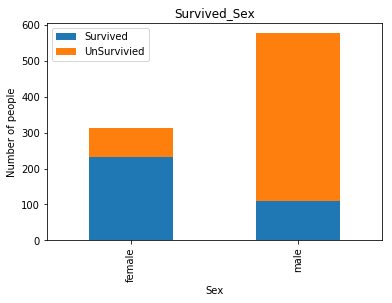

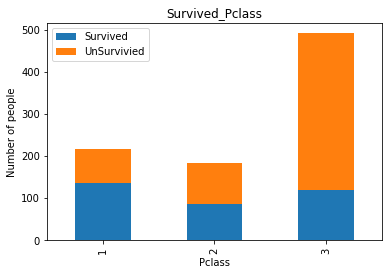

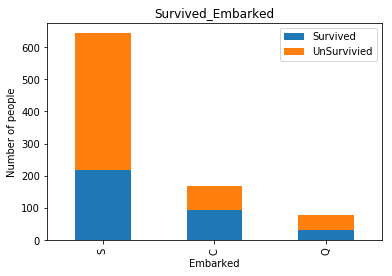

In [86]:
def print_stacked_hist(feature):
    feature_data = train_data.filter([feature, 'Survived'])
    survived_data = feature_data[feature][feature_data.Survived == 1].value_counts()
    unsurvived_data = feature_data[feature][feature_data.Survived == 0].value_counts()
    df = pd.DataFrame({'Survived': survived_data, 'UnSurvivied': unsurvived_data})
    df.plot(kind='bar', stacked=True)
    plt.title('Survived_' + feature)
    plt.xlabel(feature)
    plt.ylabel(u'Number of people')
    plt.show()

print_stacked_hist('Sex')
print_stacked_hist('Pclass')
print_stacked_hist('Embarked')

### **数据清洗**

#### 缺失值
1. 年龄缺失1/4
2. 客舱确实3/4
3. 登录港口缺失少量数据

[处理方式：拟合、填充或者参照组忽略]

In [87]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


1. Age: 年龄缺失1/4，由于特征和年龄大多没有关系，采取Step(5年)离散化+**填充**NaN新类型的方法。
2. 客舱: 缺失3/4，因为船舱可能和身份有关，所以直接使用**0/1化**。
3. 登录港口：登录港口缺失少量数据，直接**填充**为最常见类型。

##### 填充字段信息

In [345]:
def get_filled_data(train_data):
    filled_data = train_data.copy()
    # transform Age
    filled_data.loc[np.isnan(train_data['Age']), 'Age'] = 0
    def transform_category(data, start, step, category):
        """
        data是一个array数据
        """
        result = ((data - start) / step).astype(int) + category
        return result

    step = 5
    filled_data['Age'] = transform_category(filled_data['Age'], 0, step, 0)

    filled_data.loc[filled_data['Cabin'].notnull(), 'Cabin'] = 1
    filled_data.loc[filled_data['Cabin'].isnull(), 'Cabin'] = 0

    def get_most_common_category(series):
        return series.value_counts().axes[0][0]

    most_common = get_most_common_category(filled_data['Embarked'])
    filled_data.loc[filled_data['Embarked'].isnull(), 'Embarked'] = most_common
    return filled_data

filled_data = get_filled_data(train_data)
filled_test_data = get_filled_data(test_data)
filled_test_data.fillna(filled_test_data.mean(), inplace=True)
filled_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            418 non-null int64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           418 non-null float64
Cabin          418 non-null object
Embarked       418 non-null object
dtypes: float64(1), int64(5), object(5)
memory usage: 36.0+ KB


In [340]:
filled_data.info()
filled_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null int64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          891 non-null object
Embarked       891 non-null object
dtypes: float64(1), int64(6), object(5)
memory usage: 83.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            418 non-null int64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
C

#### Dummy Coding
Sex\new_Cabin和Embarked进行dummy coding

In [346]:
def get_dummied_data(new_data):
    dummy_cabin = pd.get_dummies(new_data["Cabin"], prefix="Cabin")
    dummy_sex = pd.get_dummies(new_data['Sex'], prefix='Sex')
    dummy_embarked = pd.get_dummies(new_data['Embarked'], prefix='Embarked')

    dummied_data = pd.concat([new_data, dummy_cabin, dummy_sex, dummy_embarked], axis=1)
    dummied_data.drop(['Cabin', 'Sex', 'Embarked'], axis=1, inplace=True)
    return dummied_data

dummied_data = get_dummied_data(filled_data)
dummied_test_data = get_dummied_data(filled_test_data)
dummied_data.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin_0,Cabin_1,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",4,1,0,A/5 21171,7.2500,1,0,0,1,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",7,1,0,PC 17599,71.2833,0,1,1,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",5,0,0,STON/O2. 3101282,7.9250,1,0,1,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",7,1,0,113803,53.1000,0,1,1,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",7,0,0,373450,8.0500,1,0,0,1,0,0,1


##### Feature Scaling
将fare数据归一化

In [347]:
from sklearn.preprocessing import StandardScaler
dummied_data['Fare'] = StandardScaler().fit_transform(dummied_data.filter(['Fare']))
dummied_test_data['Fare'] = StandardScaler().fit_transform(dummied_test_data.filter(['Fare']))

In [214]:
dummied_data['Fare'].describe()

count    8.910000e+02
mean     3.987333e-18
std      1.000562e+00
min     -6.484217e-01
25%     -4.891482e-01
50%     -3.573909e-01
75%     -2.424635e-02
max      9.667167e+00
Name: Fare, dtype: float64

#### 暂时去除无用字段

In [348]:
unsed_column = ['PassengerId', 'Name', 'Ticket']
target_prepared_y = dummied_data['Survived']
train_prepared_data = dummied_data.drop(unsed_column + ['Survived'], axis=1)

dummied_prepard_data = dummied_test_data.drop(unsed_column, axis=1)

In [349]:
train_prepared_data.info()
dummied_prepard_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
Pclass        891 non-null int64
Age           891 non-null int64
SibSp         891 non-null int64
Parch         891 non-null int64
Fare          891 non-null float64
Cabin_0       891 non-null uint8
Cabin_1       891 non-null uint8
Sex_female    891 non-null uint8
Sex_male      891 non-null uint8
Embarked_C    891 non-null uint8
Embarked_Q    891 non-null uint8
Embarked_S    891 non-null uint8
dtypes: float64(1), int64(4), uint8(7)
memory usage: 41.0 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
Pclass        418 non-null int64
Age           418 non-null int64
SibSp         418 non-null int64
Parch         418 non-null int64
Fare          418 non-null float64
Cabin_0       418 non-null uint8
Cabin_1       418 non-null uint8
Sex_female    418 non-null uint8
Sex_male      418 non-null uint8
Embarked_C    418 non-null uint8

##### 构建基础模型

In [302]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import cross_validation, metrics
def modelfit(alg, X, Y, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    #alg.fit(X, Y)
        
    #Predict training set:
    dtrain_predictions = alg.predict(X)
    dtrain_predprob = alg.predict_proba(X)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, X, Y, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(Y.values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(Y, dtrain_predprob))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

0.85393258427
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Model Report
Accuracy : 0.8013
AUC Score (Train): 0.850587
CV Score : Mean - 0.8400337 | Std - 0.01481652 | Min - 0.8144269 | Max - 0.8535483


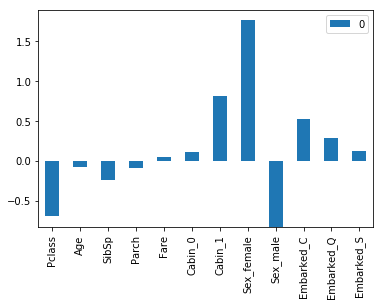

In [350]:
def train_model(model_class, print_coef=False, *args, **kwargs):
    kf = KFold(n_splits=10)
    best_lr = None
    best_score = 0
    for train_index, test_index in kf.split(train_prepared_data):
        train_sub_data, target_sub_data = train_prepared_data.loc[train_index], target_prepared_y.loc[train_index]
        test_sub_data, test_target_sub_data = train_prepared_data.loc[test_index], target_prepared_y.loc[test_index]
        lr = model_class(*args, **kwargs)
        lr.fit(train_sub_data, target_sub_data)
        score = lr.score(test_sub_data, test_target_sub_data)
        if score > best_score:
            best_lr = lr
            best_score = score

    print best_score
    print best_lr

    modelfit(best_lr, train_prepared_data, target_prepared_y, printFeatureImportance=False)
    if print_coef:
        columns = list(train_prepared_data.columns)
        plot_df = pd.DataFrame(best_lr.coef_.ravel(), index=columns)
        plot_df.plot(kind='bar')
    return best_lr

lr = train_model(LogisticRegression, print_coef=True)

In [352]:
def print_result(passage_list, result):
    for i, key in passage_list.iteritems():
        print "{0},{1}".format(key, result[i])

In [353]:
result = lr.predict(dummied_prepard_data)
passage_list = test_data['PassengerId']
print_result(passage_list, result)

892,0
893,0
894,0
895,0
896,1
897,0
898,1
899,0
900,1
901,0
902,0
903,0
904,1
905,0
906,1
907,1
908,0
909,0
910,1
911,1
912,0
913,0
914,1
915,0
916,1
917,0
918,1
919,0
920,0
921,0
922,0
923,0
924,0
925,1
926,1
927,0
928,1
929,1
930,0
931,0
932,0
933,1
934,0
935,1
936,1
937,0
938,1
939,0
940,1
941,1
942,0
943,0
944,1
945,1
946,0
947,0
948,0
949,0
950,0
951,1
952,0
953,0
954,0
955,1
956,1
957,1
958,1
959,0
960,1
961,1
962,1
963,0
964,1
965,1
966,1
967,1
968,0
969,1
970,0
971,1
972,0
973,0
974,0
975,0
976,0
977,0
978,1
979,1
980,1
981,0
982,1
983,0
984,1
985,0
986,0
987,0
988,1
989,0
990,1
991,0
992,1
993,0
994,0
995,0
996,1
997,0
998,0
999,0
1000,0
1001,0
1002,0
1003,1
1004,1
1005,1
1006,1
1007,0
1008,0
1009,1
1010,1
1011,1
1012,1
1013,0
1014,1
1015,0
1016,0
1017,1
1018,0
1019,1
1020,0
1021,0
1022,0
1023,0
1024,1
1025,0
1026,0
1027,0
1028,0
1029,0
1030,1
1031,0
1032,0
1033,1
1034,0
1035,0
1036,0
1037,0
1038,1
1039,0
1040,0
1041,0
1042,1
1043,0
1044,0
1045,1
1046,0
1047,0
1048,1
1049,1
10

In [323]:
from sklearn.tree import DecisionTreeClassifier
model = train_model(DecisionTreeClassifier, max_depth=5)

0.876404494382
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

Model Report
Accuracy : 0.8406
AUC Score (Train): 0.890849
CV Score : Mean - 0.8327145 | Std - 0.03442769 | Min - 0.7805665 | Max - 0.8726604


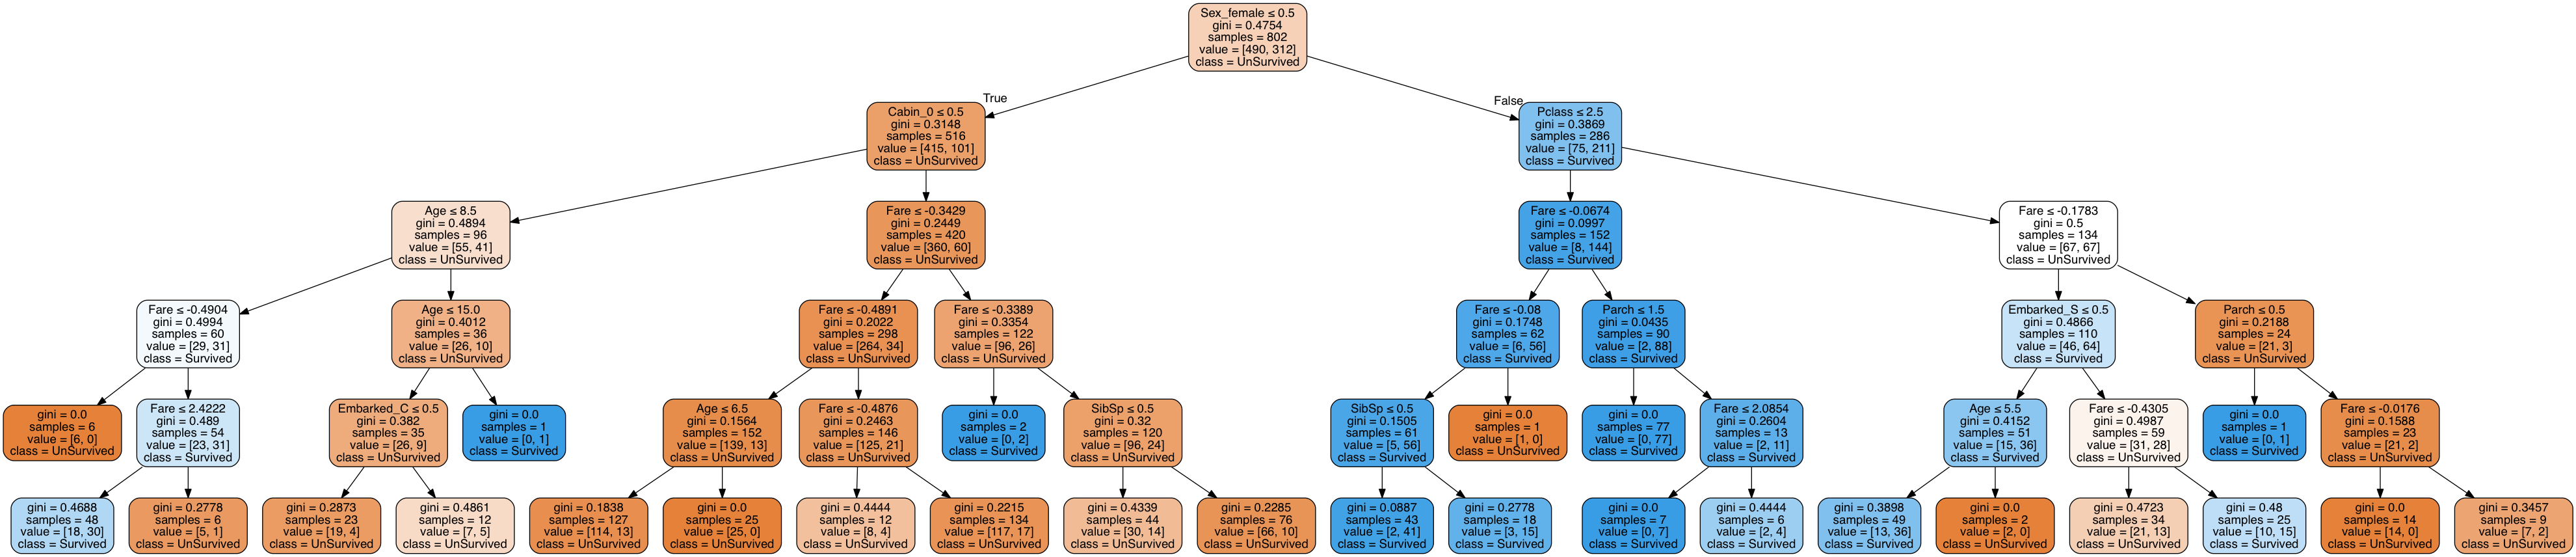

In [326]:
from IPython.display import Image
from sklearn import tree
import pydotplus
dot_data = tree.export_graphviz(model, out_file=None, 
                         feature_names=list(train_prepared_data.columns), 
                         class_names=['UnSurvived', 'Survived'],
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  

#### Training Data

In [354]:
result = model.predict(dummied_prepard_data)
passage_list = test_data['PassengerId']
print_result(passage_list, result)

892,0
893,0
894,0
895,0
896,1
897,0
898,0
899,0
900,1
901,0
902,0
903,0
904,1
905,0
906,1
907,1
908,0
909,0
910,0
911,0
912,0
913,0
914,0
915,0
916,1
917,0
918,1
919,0
920,1
921,0
922,0
923,0
924,1
925,1
926,1
927,0
928,0
929,0
930,0
931,0
932,0
933,1
934,0
935,1
936,1
937,0
938,0
939,0
940,1
941,1
942,1
943,0
944,1
945,1
946,0
947,0
948,0
949,0
950,0
951,1
952,0
953,0
954,0
955,1
956,0
957,1
958,1
959,0
960,1
961,1
962,1
963,0
964,0
965,1
966,1
967,0
968,0
969,1
970,0
971,1
972,0
973,0
974,0
975,0
976,0
977,0
978,1
979,0
980,1
981,0
982,1
983,0
984,1
985,0
986,0
987,0
988,1
989,0
990,0
991,0
992,1
993,0
994,0
995,0
996,1
997,0
998,0
999,0
1000,0
1001,1
1002,0
1003,1
1004,0
1005,1
1006,1
1007,0
1008,0
1009,1
1010,1
1011,1
1012,1
1013,0
1014,1
1015,0
1016,0
1017,1
1018,0
1019,1
1020,0
1021,0
1022,0
1023,0
1024,1
1025,0
1026,0
1027,0
1028,0
1029,0
1030,0
1031,0
1032,0
1033,1
1034,0
1035,0
1036,0
1037,0
1038,1
1039,0
1040,0
1041,0
1042,1
1043,0
1044,0
1045,1
1046,0
1047,0
1048,1
1049,0
10

#### 特征工程与特征学习

#### Prepared Data
Filling in missing value

In [165]:
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Imputer

numeric_attributes = ['Age', 'SibSp', 'Parch', 'Fare']
scatter_attributes = ['Sex', ]
one_hot_attributes = ['Pclass']
other_attributes = ['Embarked']

numeric_pipline = Pipeline([
    ('selector', DataFrameSelector(numeric_attributes)),
    ('imputer', Imputer(strategy='median')),
    ('scaler', StandardScaler()),
])
scatter_pipline = Pipeline([
    ('selector', DataFrameSelector(scatter_attributes)),
    ('imputer', CategoricalImputer()),
    ('label_binarizer', LabelBinarizer()),    
])
one_hot_pipeline = Pipeline([
    ('selector', DataFrameSelector(one_hot_attributes)),
    ('one_hot', OneHotEncoder())
])
other_pipeline = Pipeline([
    ('selector', DataFrameSelector(other_attributes)),
    ('imputer', CategoricalImputer()),
    ('label_binarizer', LabelBinarizer())
])
full_pipeline = FeatureUnion(transformer_list = [
    ('numeric_pipeline', numeric_pipline),
    ('scatter_pipeline', scatter_pipline),
    ('one_hot_pipeline', one_hot_pipeline),
    ('other_pipeline', other_pipeline)
])

X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.fit_transform(X_test)
X_test_prepared.shape

(418, 11)

#### Build A baseline Model
GDBT and RandomForest

RandomFrest: 0.71770

GBDT: 0.75120

In [147]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
for_clf = RandomForestClassifier()
for_clf.fit(X_train_prepared, y_train)
result = for_clf.predict(X_test_prepared)

passage_list = test_data['PassengerId']

In [148]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train_prepared, y_train)
result = gb_clf.predict(X_test_prepared.toarray())

passage_list = test_data['PassengerId']
# print_result(passage_list, result)

#### Analysis Baseline Model

In [33]:
av_hack = pd.read_csv("../data/av/Test_bCtAN1w.csv")

In [34]:
av_hack.head()

,ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,...,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4
0,ID000026A10,Male,Dehradun,21500,03-Apr-87,05-May-15,100000.0,3.0,0.0,APTARA INC,...,100000.0,3.0,20.0,1000.0,2649.39,N,Web-browser,B,S122,3
1,ID000054C40,Male,Mumbai,42000,12-May-80,01-May-15,0.0,0.0,0.0,ATUL LTD,...,690000.0,5.0,24.0,13800.0,19849.90,Y,Mobile,C,S133,5
2,ID000066O10,Female,Jaipur,10000,19-Sep-89,01-May-15,300000.0,2.0,0.0,SHAREKHAN PVT LTD,...,NaN,NaN,NaN,NaN,NaN,N,Web-browser,B,S133,1
3,ID000110G00,Female,Chennai,14650,15-Aug-91,01-May-15,0.0,0.0,0.0,MAERSK GLOBAL SERVICE CENTRES,...,NaN,NaN,NaN,NaN,NaN,N,Mobile,C,S133,1
4,ID000113J30,Male,Chennai,23400,22-Jul-87,01-May-15,100000.0,1.0,5000.0,SCHAWK,...,100000.0,2.0,NaN,NaN,NaN,N,Web-browser,B,S143,1


#### Tune parameters
1. GridSearchCV
2. Randomized Search


Model Report
Accuracy : 0.8945
AUC Score (Train): 0.953760
CV Score : Mean - 0.8755126 | Std - 0.03125096 | Min - 0.8268775 | Max - 0.9109552


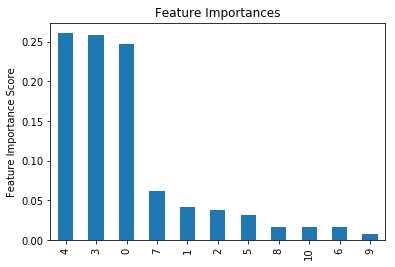

In [149]:
param_test = {'min_samples_split':range(2, 20, 2), 'min_samples_leaf':range(1,10,1), 'learning_rate': (0.05, 0.2, 0.05)}
gv_search = GridSearchCV(estimator = GradientBoostingClassifier(n_estimators=60,max_depth=9,max_features='sqrt', subsample=0.8, random_state=10,), 
param_grid = param_test, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gv_search.fit(X_train_prepared.toarray(), y_train)
gv_search.grid_scores_, gv_search.best_params_, gv_search.best_score_
modelfit(gv_search.best_estimator_, X_train_prepared, y_train)

In [75]:
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

In [103]:
from scipy.stats import randint as sp_randint
param_dist = {
    'min_samples_split':sp_randint(2, 50),
    'min_samples_leaf':sp_randint(1, 50),
    'max_depth': sp_randint(2, 20),
    'learning_rate': [0.05, 0.1, 0.15, 0.20],
    'subsample': [0.7, 0.75, 0.8, 0.85, 0.90],
    'max_features': sp_randint(1, 10),
}

from sklearn.model_selection import RandomizedSearchCV
clf = GradientBoostingClassifier(n_estimators=60,max_depth=9,max_features='sqrt', subsample=0.8, random_state=10)
gv_search = RandomizedSearchCV(clf, param_distributions=param_dist,
    n_iter=400, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gv_search.fit(X_train_prepared.toarray(), y_train)
gv_search.grid_scores_, gv_search.best_params_, gv_search.best_score_
# modelfit(gv_search.best_estimator_, X_train_prepared, y_train)

/usr/local/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.87127, std: 0.02605, params: {u'learning_rate': 0.15, u'min_samples_leaf': 31, u'subsample': 0.85, u'min_samples_split': 23, u'max_features': 6, u'max_depth': 15},
  mean: 0.86897, std: 0.02567, params: {u'learning_rate': 0.15, u'min_samples_leaf': 21, u'subsample': 0.8, u'min_samples_split': 48, u'max_features': 9, u'max_depth': 9},
  mean: 0.86747, std: 0.02839, params: {u'learning_rate': 0.15, u'min_samples_leaf': 28, u'subsample': 0.7, u'min_samples_split': 28, u'max_features': 9, u'max_depth': 7},
  mean: 0.86346, std: 0.02980, params: {u'learning_rate': 0.15, u'min_samples_leaf': 12, u'subsample': 0.8, u'min_samples_split': 15, u'max_features': 5, u'max_depth': 16},
  mean: 0.86473, std: 0.02877, params: {u'learning_rate': 0.2, u'min_samples_leaf': 38, u'subsample': 0.8, u'min_samples_split': 23, u'max_features': 2, u'max_depth': 15},
  mean: 0.84838, std: 0.02270, params: {u'learning_rate': 0.05, u'min_samples_leaf': 37, u'subsample': 0.7, u'min_samples_split': 14, u'm

In [150]:
result = gv_search.best_estimator_.predict(X_test_prepared.toarray())
print_result(passage_list, result)

892,0
893,0
894,0
895,0
896,0
897,0
898,1
899,0
900,1
901,0
902,0
903,0
904,1
905,0
906,1
907,1
908,0
909,0
910,1
911,0
912,1
913,0
914,1
915,0
916,1
917,0
918,1
919,0
920,1
921,0
922,0
923,0
924,0
925,0
926,1
927,0
928,1
929,0
930,0
931,0
932,0
933,0
934,0
935,1
936,1
937,0
938,0
939,0
940,1
941,0
942,0
943,0
944,1
945,1
946,0
947,0
948,0
949,0
950,0
951,1
952,0
953,0
954,0
955,1
956,1
957,1
958,1
959,0
960,0
961,1
962,1
963,0
964,1
965,0
966,1
967,0
968,0
969,1
970,0
971,1
972,1
973,0
974,0
975,0
976,0
977,0
978,1
979,1
980,1
981,1
982,0
983,0
984,1
985,0
986,0
987,0
988,1
989,0
990,1
991,0
992,1
993,0
994,0
995,0
996,1
997,0
998,0
999,0
1000,0
1001,0
1002,0
1003,1
1004,1
1005,1
1006,1
1007,0
1008,0
1009,1
1010,1
1011,1
1012,1
1013,0
1014,1
1015,0
1016,0
1017,1
1018,0
1019,1
1020,0
1021,0
1022,0
1023,0
1024,0
1025,0
1026,0
1027,0
1028,0
1029,0
1030,1
1031,0
1032,0
1033,1
1034,0
1035,0
1036,0
1037,0
1038,0
1039,0
1040,0
1041,0
1042,1
1043,0
1044,0
1045,1
1046,0
1047,0
1048,1
1049,1
10